<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/projouts/projects/ReinforcementLearning/lunar_lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance Analysis of DQN Algorithm on the Lunar Lander task

**By Neuromatch Academy**

__Content Creators:__ Raghuram Bharadwaj Diddigi, Geraud Nangue Tasse, Yamil Vidal, Sanjukta Krishnagopal, Sara Rajaee

__Content editors:__ Spiros Chavlis

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective

In this project, the objective is to analyze the performance of the Deep Q-Learning algorithm on an exciting task- Lunar Lander. Before we describe the task, let us focus on two keywords here - analysis and performance. What exactly do we mean by these keywords in the context of Reinforcement Learning (RL)?

---
# Setup

In [1]:
# @title Install dependencies
!pip install stable-baselines3 > /dev/null
!pip install box2d-py > /dev/null
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
# Imports
import io
import os
import glob
import torch
import base64
import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gym
from gym import spaces
from gym.wrappers import Monitor

In [3]:
# @title Plotting/Video functions
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

---
# Introduction

In a standard RL setting, an agent learns optimal behavior from an environment through a feedback mechanism to maximize a given objective. Many algorithms have been proposed in the RL literature that an agent can apply to learn the optimal behavior. One such popular algorithm is the Deep Q-Network (DQN). This algorithm makes use of deep neural networks to compute optimal actions. In this project, your goal is to understand the effect of the number of neural network layers on the algorithm's performance. The performance of the algorithm can be evaluated through two metrics - Speed and Stability. 

**Speed:** How fast the algorithm reaches the maximum possible reward. 

**Stability** In some applications (especially when online learning is involved), along with speed, stability of the algorithm, i.e., minimal fluctuations in performance, is equally important. 

In this project, you should investigate the following question:

**What is the impact of number of neural network layers on speed and stability of the algorithm?**

You do not have to write the DQN code from scratch. We have provided a basic implementation of the DQN algorithm. You only have to tune the hyperparameters (neural network size, learning rate, etc), observe the performance, and analyze. More details on this are provided below. 

Now, let us discuss the RL task we have chosen, i.e., Lunar Lander. This task consists of the lander and a landing pad marked by two flags. The episode starts with the lander moving downwards due to gravity. The objective is to land safely using different engines available on the lander with zero speed on the landing pad as quickly and fuel efficient as possible. Reward for moving from the top of the screen and landing on landing pad with zero speed is between 100 to 140 points. Each leg ground contact yields a reward of 10 points. Firing main engine leads to a reward of -0.3 points in each frame. Firing the side engine leads to a reward of -0.03 points in each frame. An additional reward of -100 or +100 points is received if the lander crashes or comes to rest respectively which also leads to end of the episode. 

The input state of the Lunar Lander consists of following components:

  1. Horizontal Position
  2. Vertical Position
  3. Horizontal Velocity
  4. Vertical Velocity
  5. Angle
  6. Angular Velocity
  7. Left Leg Contact
  8. Right Leg Contact

The actions of the agents are:
  1. Do Nothing
  2. Fire Main Engine
  3. Fire Left Engine
  4. Fire Right Engine


<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/static/lunar_lander.png">

---
# Basic DQN Implementation

We will now implement the DQN algorithm using the existing code base. We encourage you to understand this example and re-use it in an application/project of your choice! 

Now, let us set some hyperparameters for our algorithm. This is the only part you would play around with, to solve the first part of the project. 

In [4]:
nn_layers = [64,64] #This is the configuration of your neural network. Currently, we have two layers, each consisting of 64 neurons. 
                    #If you want three layers with 64 neurons each, set the value to [64,64,64] and so on. 

learning_rate = 0.001 #This is the step-size with which the gradient descent is carried out. 
                      #Tip: Use smaller step-sizes for larger networks. 
                    

Now, let us setup our model and the DQN algorithm. 

In [5]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = gym.make('LunarLander-v2')
#You can also load other environments like cartpole, MountainCar, Acrobot. Refer to https://gym.openai.com/docs/ for descriptions.
#For example, if you would like to load Cartpole, just replace the above statement with "env = gym.make('CartPole-v1')". 

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env,log_path = log_dir, deterministic=True) #For evaluating the performance of the agent periodically and logging the results.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)
model = DQN("MlpPolicy", env,policy_kwargs = policy_kwargs, 
            learning_rate=learning_rate,
            batch_size=1,  #for simplicity, we are not doing batch update.
            buffer_size=1, #size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=1, #learning starts immediately!
            gamma=0.99, #discount facto. range is between 0 and 1. 
            tau = 1,  #the soft update coefficient for updating the target network
            target_update_interval=1, #update the target network immediately.
            train_freq=(1,"step"), #train the network at every step.
            max_grad_norm = 10, #the maximum value for the gradient clipping
            exploration_initial_eps = 1, #initial value of random action probability
            exploration_fraction = 0.5, #fraction of entire training period over which the exploration rate is reduced
            gradient_steps = 1, #number of gradient steps 
            seed = 1, #seed for the pseudo random generators
            verbose=0) #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1. 

# You can also experiment with other RL algorithms like A2C, PPO, DDPG etc. Refer to  https://stable-baselines3.readthedocs.io/en/master/guide/examples.html
#for documentation. For example, if you would like to run DDPG, just replace "DQN" above with "DDPG".

Before we train the model, let us look at an instance of Lunar Lander **before training**.  

**Note:** The following code for rendering the video is taken from https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=T9RpF49oOsZj

In [6]:
test_env = wrap_env(gym.make("LunarLander-v2"))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action) 
  total_reward += reward
  if done: 
    break;

# print(total_reward)
test_env.close()
show_video()

From the video above, we see that the lander has crashed! 
It is now the time for training! 


In [7]:
model.learn(total_timesteps=100000, log_interval=10, callback=callback)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode. 

Eval num_timesteps=10000, episode_reward=-626.57 +/- 108.89
Episode length: 96.80 +/- 19.65
New best mean reward!
Eval num_timesteps=20000, episode_reward=-565.73 +/- 53.94
Episode length: 96.60 +/- 21.43
New best mean reward!
Eval num_timesteps=30000, episode_reward=-1248.76 +/- 1155.29
Episode length: 179.20 +/- 94.89
Eval num_timesteps=40000, episode_reward=-653.29 +/- 100.22
Episode length: 205.80 +/- 44.69
Eval num_timesteps=50000, episode_reward=-657.19 +/- 29.71
Episode length: 885.00 +/- 85.80
Eval num_timesteps=60000, episode_reward=120.18 +/- 92.77
Episode length: 563.40 +/- 67.10
New best mean reward!
Eval num_timesteps=70000, episode_reward=114.92 +/- 106.17
Episode length: 677.00 +/- 109.39
Eval num_timesteps=80000, episode_reward=123.18 +/- 119.30
Episode length: 334.60 +/- 93.25
New best mean reward!
Eval num_timesteps=90000, episode_reward=210.39 +/- 15.48
Episode length: 467.80 +/- 55.01
New best mean reward!
Eval num_timesteps=100000, episode_reward=216.02 +/- 61.37
E

The training takes time. We encourage you to analyze the output logs (set verbose to 1 to print the output logs). The main component of the logs that you should track is "ep_rew_mean" (mean of episode rewards). As the training proceeds, the value of "ep_rew_mean" should increase. The improvement need not be monotonic, but the trend should be upwards! 

Along with training, we are also periodically evaluating the performance of the current model during the training. This was reported in logs as follows:

*Eval num_timesteps=100000, episode_reward=63.41 +/- 130.02*

*Episode length: 259.80 +/- 47.47* 



Now, let us look at the visual performance of the lander. 

**Note:** The performance varies across different seeds and runs. This code is not optimized to be stable across all runs and seeds. We hope you will be able to find an optimal configuration! 

In [8]:
env = wrap_env(gym.make("LunarLander-v2"))
observation = env.reset()
while True:
  env.render()
  action, _states = model.predict(observation, deterministic=True)
  observation, reward, done, info = env.step(action) 
  if done: 
    break;
            
env.close()
show_video()

The lander has landed safely!!

Let us analyze its performance (speed and stability). For this purpose, we plot the number of time steps on the X-axis and the episodic reward given by the trained model on the Y-axis. 

Text(0, 0.5, 'Episode Rewards')

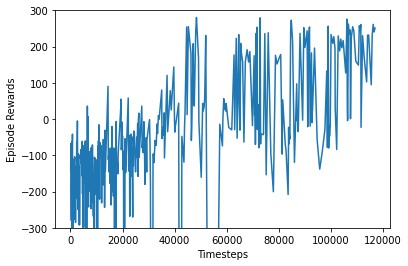

In [9]:
x, y = ts2xy(load_results(log_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting. 
plt.plot(x,y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')

From the above plot, we observe that, although the maximum reward is achieved quickly. Achieving an episodic reward of > 200 is good. We see that the agent has achieved it in less than 50000 timesteps (speed is good!). However, there are a lot of fluctuations in the performance (stability is not good!). 

Your objective now is to modify the model parameters (nn_layers, learning_rate in the code cell #2 above), run all the cells following it and investigate the stability and speed of the chosen configuration.   


---
# Additional Project Ideas

## 1 Play with exploration-exploitation trade-off

Exploration (selecting random actions) and exploitation (selecting greedy action) is a crucial component of the DQN algorithm. Explore random actions for a long time will slow down the training process. At the same time, if all actions are not explored enough, it might lead to a sub-optimal performance. In the DQN code above, we have used the following parameters:

In [10]:
exploration_initial_eps = 1  # initial value of random action probability. Range is between 0 and 1.
exploration_fraction = 0.5  # fraction of entire training period over which the exploration rate is reduced. Range is between 0 and 1.
exploration_final_eps = 0.05  # (set by defualt) final value of random action probability. Range is between 0 and 1. 

Your objective is to play around with these parameters and analyze their performance (speed and stability). You can modify these parameters and set them as arguments in DQN(...,exploration_initial_eps = 1, exploration_fraction = 0.5, exploration_final_eps = 0.05,...). 

## 2 Reward Shaping

Your objective here is to construct a modified reward function that improves the performance of the Lunar Lander. To this end, you would have to create your own custom environment. An example of a custom environment is given below:

In [11]:
# Taken from https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html
class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, arg1, arg2):
    super(CustomEnv, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
    self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
    # Example for using image as input (channel-first; channel-last also works):
    self.observation_space = spaces.Box(low=0, high=255,
                                        shape=(N_CHANNELS, HEIGHT, WIDTH), dtype=np.uint8)

  def step(self, action):
    ...
    return observation, reward, done, info
  def reset(self):
    ...
    return observation  # reward, done, info can't be included
  def render(self, mode='human'):
    ...
  def close (self):
    ...

As you are only changing the reward structure, you can inherit the original Lunar Lander environment from https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py and modify just the "step" function. Focus on modifying the following part of the code in the "step" function


In [12]:
def step(self, actions):
  ...
  ...
  ...
  reward = 0
  shaping = (
      -100 * np.sqrt(state[0] * state[0] + state[1] * state[1])
      - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])
      - 100 * abs(state[4])
      + 10 * state[6]
      + 10 * state[7]
  )  # And ten points for legs contact, the idea is if you
  # lose contact again after landing, you get negative reward
  if self.prev_shaping is not None:
      reward = shaping - self.prev_shaping
  self.prev_shaping = shaping

  reward -= (
      m_power * 0.30
  )  # less fuel spent is better, about -30 for heuristic landing. You should modify these values. 
  reward -= s_power * 0.03

  done = False
  if self.game_over or abs(state[0]) >= 1.0:
      done = True
      reward = -100 
  if not self.lander.awake:
      done = True
      reward = +100
  return np.array(state, dtype=np.float32), reward, done, {}

Once you have cutomized your own environment, you can execute that environment by just calling:

In [13]:
#Enter the name of the custome environment you created and uncomment the line below. 
#env = Custom_LunarLander() 
# Refer to https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html, if you would like to create more complex environments.

## 3 Identify the state information crucial to its performance.

Your objective here is to alter the input state information and analyze the performance. The input state of the Lunar Lander consists of following components:

  1. Horizontal Position
  2. Vertical Position
  3. Horizontal Velocity
  4. Vertical Velocity
  5. Angle
  6. Angular Velocity
  7. Left Leg Contact
  8. Right Leg Contact

You can train the algorithm by masking one of the eight components at a time and understand how that affects the performance of the algorithm. Similar to the reward shaping task, you would have to create a custom environment and modify the state space. Again, you can inherit all the necessary functions and modify the following portion of the "Step" function:

In [14]:
def step(self, actions):
  ...
  ...
  ...
  state = [ # Remove one component at a time to investigate the effect on performance!
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.lander.angle,
            20.0 * self.lander.angularVelocity / FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0,
        ]

## 4 Extension to Atari Games

In the Lunar Lander task, the input to the algorithm is a vector of state information. Deep RL algorithms can also be applied when the input to the training is image frames, which is the case in the Atari games. For example, consider an Atari game - Pong. In this environment, the observation is an RGB image of the screen, which is an array of shape (210, 160, 3). To train the Pong game, you can start with the following sample code:

In [15]:
#Necessary components required for running Atari games.
#Taken from https://github.com/openai/atari-py/issues/83#issuecomment-864356148
! wget http://www.atarimania.com/roms/Roms.rar > /dev/null
! mkdir /content/ROM/ > /dev/null
! unrar e /content/Roms.rar /content/ROM/ > /dev/null
! python -m atari_py.import_roms /content/ROM/ > /dev/null

--2021-08-03 21:03:08--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   474KB/s    in 24s     

2021-08-03 21:03:32 (457 KB/s) - ‘Roms.rar’ saved [11128004/11128004]



In [16]:
# Taken from: https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/atari_games.ipynb#scrollTo=f3K4rMXwimBO
env = make_atari_env('PongNoFrameskip-v4', n_envs=1, seed=0)
#Atari Games take a lot of memory. Following commands crash on Coalb. Run the following code on Colab Pro or your local Jupyter notebook!
# env = VecFrameStack(env, n_stack=4)
# model = DQN('CnnPolicy', env, verbose=1)  # Note the difference here! We use 'CnnPolicy" here instead of 'MlpPolicy' as the input is frames. 
# model.learn(total_timesteps=1) #change the number of timesteps as desired and run this command!

## 5 Obstacle Avoidance and Transfer Learning

Your obstacle here is to add an obstacle in the path of the lunar lander (by creating a custom environment as described in point 2 above) and train the model such that the lander lands safely, avoiding collisions. 

You would first want to devise a mechansim for adding obstacles. For example, you could have an imaginary obstacle at some horizantal and vertical position cooridnates and modify the reward function such that a penalty is levied if the lander comes close to it. 

An interesting approach to solve this problem is to apply the techniques of transfer learning. For example, you could initialise the neural network model with the weights of the trained model on the original problem to improve the sample effeciency. This can be done using the following code:

In [17]:
#Specify the load path and uncomment below: 
# model = load(load_path,
#              env=gym.make('LunarLander-v2'),
#              custom_objects=None, **kwargs)

Following are some of the resources on transfer learning that you would want to start with. 

**Research Papers**

Surveys:
1. (Long, Old, Highly cited) Taylor, M. E.,  et al. (2009). Transfer learning for reinforcement learning domains. https://www.jmlr.org/papers/volume10/taylor09a/taylor09a.pdf

2. (Medium, Old, Good for a quick read) Lazaric, A. (2012). Transfer in reinforcement learning: a framework and a survey. https://hal.inria.fr/docs/00/77/26/26/PDF/transfer.pdf

3. (Medium, Recent, Good for a quick read) Zhu, Z., Lin, K., & Zhou, J. (2020). Transfer learning in deep reinforcement learning. https://arxiv.org/pdf/2009.07888.pdf

4. Specific example:
Barreto, A., et al. (2016).  Successor features for transfer in reinforcement learning. https://arxiv.org/pdf/1606.05312

## 5(b) Transfer Learning in minigrid environment

These are some simple gridworld gym environments designed to be particularly simple, lightweight and fast. Refer to https://github.com/maximecb/gym-minigrid for description of the environments. An example to load a minigrid environment is given below:

In [18]:
!pip install gym-minigrid > /dev/null
import gym_minigrid
env = gym.make('MiniGrid-Empty-5x5-v0')

You can train a standard DQN agent in this env by wrapping the env with full image observation wrappers:


In [19]:
env = gym_minigrid.wrappers.ImgObsWrapper(gym_minigrid.wrappers.RGBImgObsWrapper(env))

Note that with full image observations, the shape of the image observations may differ between envs. For e.g., MiniGrid-Empty-5x5-v0 is (40,40,3) while MiniGrid-Empty-8x8-v0 is (64,64,3). So you may need to resize the observations for transfer learning to work with the same DQN architecture.

Now try training a DQN (or another method) in one (or multiple) minigrid env(s),and see if that knowledge transfers to another (or multiple other) minigrid env(s).


## 6 Preference-Based RL (PBRL)

PBRL is an exciting sub-area in RL where the traditional reward structure is replaced with human preferences. This setting is very useful in applications where it is difficult to construct a reward function. 

In the earlier section, we have successfully trained the lunar lander to land safely. Here, the path that the lander follows to land safely can be arbitrary. In this project, using the techniques of PBRL, you will solve the lunar lander problem with an additional requirement that the lander should follow a specially curated path (for example, a straight line path). Following are some of the resources that will help you to get started with this project. 

**Research papers:**
1. Deep Reinforcement Learning
from Human Preferences https://papers.nips.cc/paper/2017/file/d5e2c0adad503c91f91df240d0cd4e49-Paper.pdf
2. Deep Q-learning from Demonstrations https://arxiv.org/pdf/1704.03732.pdf
3. Reward learning from human preferences https://arxiv.org/pdf/1811.06521.pdf
4. T-REX https://arxiv.org/pdf/1904.06387.pdf

**Code Bases:**
1. https://github.com/nottombrown/rl-teacher
2. https://github.com/hiwonjoon/ICML2019-TREX


---
# References

1. Stable Baselines Framework: https://stable-baselines3.readthedocs.io/en/master/guide/examples.html

2. Lunar Lander Environment: https://gym.openai.com/envs/LunarLander-v2/

3. OpenAI gym environments: https://gym.openai.com/docs/

4. A good reference for introduction to RL: http://incompleteideas.net/book/the-book-2nd.html
